## REINFORCEMENT LEARNING

**Group Number:** 14  
**Student Names:** Andrea Fruttidoro (66373); Pedro Fanica (54346); Quentin Weiss (66292);

---
---

## 0.&nbsp;Useful Tools

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import itertools
from tqdm.auto import tqdm
from scipy import stats

In [9]:
# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

# =============================================================================
# 1. ENVIRONMENT
# =============================================================================
rng = np.random.default_rng(42) # Fixed seed for reproducibility

class PatientEnv:
    """
    Environment simulator for patient treatment using Q-learning.
    1. State Initialization from Learned Distribution
    2. Transition Dynamics via Transition Matrix
    3. Reward Retrieval from Reward Table
    4. Episode Termination based on Horizon
    """
    def __init__(self, pi, trans_mat, r_sa, horizon=6, rng=None):
        self.pi = pi
        self.P = trans_mat
        self.R = r_sa
        self.horizon = horizon
        self.rng = np.random.default_rng() if rng is None else rng
        self.reset()

    def reset(self):
        self.t = 0
        # Sample initial state from the learned distribution pi
        self.s = self.rng.choice(len(self.pi), p=self.pi)
        return self.s

    def step(self, a):
        # Retrieve expected reward from the table
        r = float(self.R[self.s, a])
        
        # Sample next state using the transition matrix P(s' | s, a)
        s_next = self.rng.choice(len(self.pi), p=self.P[self.s, a])
        
        # Update internal state
        self.s = s_next
        self.t += 1
        
        # finish episode if horizon reached
        done = (self.t >= self.horizon)
        return s_next, r, done, {}
    
# =============================================================================
# 2. Q-LEARNING AGENT
# =============================================================================

class QLearningAgent:
    """
    Tabular Q-learning agent.
    1. Epsilon-Greedy Action Selection
    2. Q-Value Update using Bellman Equation
    3. Epsilon Decay (Exponential or Linear)
    4. Training Loop
    5. Q-Table Reset for Grid Search
    """
    def __init__(self, env, n_states, n_actions, seed=42):
        self.env = env
        self.n_states = n_states
        self.n_actions = n_actions
        self.rng = np.random.default_rng(seed)
        self.Q = np.zeros((n_states, n_actions))
        self.training_rewards = []
        
    def reset_q_table(self):
        """Resets Q-table to zeros for a fresh training run."""
        self.Q = np.zeros((self.n_states, self.n_actions))
        self.training_rewards = []

    def get_epsilon(self, episode, n_episodes, initial=1.0, final=0.01, exp_decay=True, decay_rate=0.005):
        """Calculates epsilon based on the decay strategy."""
        if exp_decay:
            return max(final, initial * np.exp(-decay_rate * episode))
        else: # linear
            return  initial - (episode * (initial - final) / n_episodes)

    def get_action(self, state, epsilon):
        """Epsilon-greedy action selection."""
        if self.rng.random() < epsilon:
            return self.rng.integers(0, self.n_actions)
        else:
            # Greedy selection (breaking ties randomly)
            values = self.Q[state, :]
            return self.rng.choice(np.flatnonzero(values == values.max()))

    def train(self, n_episodes=1000, eta=0.1, gamma=0.9, 
              epsilon_start=1.0, epsilon_min=0.01, exp_decay=True, decay_rate=0.005):
        """
        Main training loop. 
        Resets Q-table at the start to ensure clean grid search runs.
        Parameters:
        - n_episodes: Number of training episodes
        - eta: Learning rate
        - gamma: Discount factor
        - epsilon_start: Initial exploration rate
        - epsilon_min: Minimum exploration rate
        - exp_decay: Whether to use exponential decay for epsilon
        - decay_rate: Decay rate for epsilon if using exponential decay
        Returns:
        - Q: Learned Q-table
        - training_rewards: List of cumulative rewards per episode
        """
        self.reset_q_table()
        
        for episode in range(n_episodes):
            state = self.env.reset()
            episode_reward = 0
            
            # Calculate current epsilon
            epsilon = self.get_epsilon(episode, n_episodes, epsilon_start, epsilon_min, exp_decay, decay_rate)
            
            while True:
                # 1. Select Action
                action = self.get_action(state, epsilon)
                
                # 2. Step Environment
                next_state, reward, done, _ = self.env.step(action)
                
                # 3. Update Q-Value (Bellman Equation)
                best_next_val = np.max(self.Q[next_state, :])
                td_target = reward + gamma * best_next_val
                td_error = td_target - self.Q[state, action]
                
                self.Q[state, action] += eta * td_error
                
                # 4. Transition
                state = next_state
                episode_reward += reward
                
                if done:
                    break
            
            self.training_rewards.append(episode_reward)
        
        return self.Q, self.training_rewards

# =============================================================================
# 3. EVALUATION & GRID SEARCH
# =============================================================================
def evaluate_policy(env, policy_fn, Q=None, episodes=1000, seed=42):
    """
    Evaluates a given policy over multiple episodes.
    Parameters:
    - env: The environment to evaluate in
    - policy_fn: Function that takes (state, Q, rng) and returns action
    - Q: Q-table (if needed by policy_fn)
    - episodes: Number of episodes to run
    - seed: Random seed for reproducibility
    Returns:
    - returns: Array of cumulative rewards per episode
    """
    rng = np.random.default_rng(seed)
    returns = []
    for _ in range(episodes):
        s = env.reset()
        G = 0.0
        # Use env.horizon to limit steps
        for t in range(env.horizon):
            # policy_fn signature: (s, Q, rng)
            a = policy_fn(s, Q, rng)
            s, r, done, _ = env.step(a)
            G += r
            if done: break
        returns.append(G)
    return np.array(returns)

def run_grid_search(agent, env, param_grid, n_eval_episodes=500):
    """
    Runs a grid search over hyperparameters.
    Parameters:
    - agent: QLearningAgent instance
    - env: Environment instance
    - param_grid: Dictionary of hyperparameters to search
    - n_eval_episodes: Number of episodes for policy evaluation
    Returns:
    - best_params: Hyperparameters yielding the best average reward
    - best_score: Best average reward achieved
    - results: List of all parameter combinations and their scores
    """
    keys, values = zip(*param_grid.items())
    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    best_score = -np.inf
    best_params = None
    results = []
    
    print(f"Starting Grid Search with {len(combinations)} candidates...")
    
    # Wrap the loop with tqdm for the progress bar
    # 'desc' adds a label to the bar
    for params in tqdm(combinations, desc="Hyperparameter Search"):
        
        # 1. Train Agent
        agent.train(**params)
        
        # 2. Evaluate Agent (Greedy)
        greedy_fn = lambda s, Q, rng: agent.get_action(s, epsilon=0.0)
        avg_reward = np.mean(evaluate_policy(env, greedy_fn, Q=agent.Q, episodes=n_eval_episodes))
        
        # 3. Store Results
        results.append({**params, 'score': avg_reward})
        
        # 4. Update Best Score
        if avg_reward > best_score:
            best_score = avg_reward
            best_params = params
            
    print(f"\nGrid Search Complete. Best Score: {best_score:.4f}")
    print(f"Best Parameters: {best_params}")
    
    return best_params, best_score, results

# =============================================================================
# 4. RETRAINING & LEARNING CURVE
# =============================================================================

def plot_learning_curve(rewards, window=100):
    """
    Plots the learning curve of the agent.
    Parameters:
    - rewards: List or array of episode rewards
    - window: Window size for moving average smoothing
    """
    plt.figure(figsize=(12, 5))
    moving_avg = pd.Series(rewards).rolling(window=window).mean()
    plt.plot(rewards, alpha=0.15, color='gray', label='Episode Reward')
    plt.plot(moving_avg, color='blue', linewidth=2, label=f'Moving Avg ({window})')
    plt.title("Agent Learning Curve: Cumulative Reward over Training")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# =============================================================================
# 5. Q-TABLE INSPECTION
# =============================================================================

def plot_q_heatmap(Q):
    """
    Plots a heatmap of the Q-table.
    Parameters:
    - Q: Q-table (2D array) with shape (num_states, num_actions)
    """
    plt.figure(figsize=(8, 5))
    state_labels = list(STATES.keys()) if 'STATES' in globals() else range(Q.shape[0])
    action_labels = list(ACTIONS.keys()) if 'ACTIONS' in globals() else range(Q.shape[1])
    
    sns.heatmap(Q, annot=True, fmt=".2f", cmap="RdYlGn", 
                xticklabels=action_labels, yticklabels=state_labels)
    plt.title("Learned Q-Values (Policy Preference)")
    plt.xlabel("Action")
    plt.ylabel("Patient State")
    plt.tight_layout()
    plt.show()

# =============================================================================
# 6. STATISTICAL POLICY EVALUATION
# =============================================================================

def cohens_d(group1, group2):
    """
    Calculates Cohen's d effect size for two independent samples.
    Parameters:
    - group1: First sample (array-like)
    - group2: Second sample (array-like)
    Returns:
    - Cohen's d value (float)
    """
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    
    # Pooled standard deviation
    pooled_se = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    return (np.mean(group1) - np.mean(group2)) / pooled_se

def compare_policies(env, agent, n_episodes=1000):
    """
    Evaluates policies and performs statistical hypothesis testing.
    Parameters:
    - env: Environment instance
    - agent: Trained QLearningAgent instance
    - n_episodes: Number of episodes to evaluate each policy
    1. Descriptive Metrics (Mean, Std, Median, Min, Max)
    2. Hypothesis Testing (Kruskal-Wallis, Mann-Whitney U, Cohen's d)
    3. Distribution Plot (Violin + Boxplot)
    4. Print Results
    5. Visualize Distribution of Rewards
    6. Interpret Statistical Findings
    """
    # Define Policy Wrappers
    policies = {
        'Random': random_policy_fn,
        'Heuristic': heuristic_policy_fn,
        'Learned (RL)': lambda s, Q, rng: agent.get_action(s, epsilon=0.0)
    }
    
    results = []
    
    print(f"\nEvaluating policies over {n_episodes} episodes each...")
    for name, func in policies.items():
        scores = evaluate_policy(env, func, Q=agent.Q, episodes=n_episodes)
        for score in scores:
            results.append({'Policy': name, 'Reward': score})
            
    df_res = pd.DataFrame(results)
    
    # --- A. DESCRIPTIVE METRICS ---
    metrics = df_res.groupby('Policy')['Reward'].agg(['mean', 'std', 'median', 'min', 'max'])
    metrics = metrics.sort_values(by='mean', ascending=False)
    
    print("\n--- Performance Metrics ---")
    print(metrics)
    
    # --- B. HYPOTHESIS TESTING ---
    print("\n--- Statistical Analysis (Hypothesis Testing) ---")
    
    # Extract arrays
    r_learned = df_res[df_res['Policy'] == 'Learned (RL)']['Reward'].values
    r_heuristic = df_res[df_res['Policy'] == 'Heuristic']['Reward'].values
    r_random = df_res[df_res['Policy'] == 'Random']['Reward'].values
    
    # 1. Global Check: Kruskal-Wallis H-test
    # Tests null hypothesis that distributions are the same
    stat, p_kw = stats.kruskal(r_learned, r_heuristic, r_random)
    print(f"1. Kruskal-Wallis Test (Global): Statistic={stat:.2f}, p-value={p_kw:.4e}")
    if p_kw < 0.05:
        print("   -> Result: Significant difference found between groups.")
    else:
        print("   -> Result: No significant difference detected.")

    print("\n2. Pairwise Comparisons (Mann-Whitney U & Effect Size):")
    # We test if Learned > Baseline (alternative='greater')
    
    comparisons = [('Heuristic', r_heuristic), ('Random', r_random)]
    
    for base_name, base_data in comparisons:
        # Mann-Whitney U test (Non-parametric t-test equivalent)
        stat, p_mwu = stats.mannwhitneyu(r_learned, base_data, alternative='greater')
        
        # Cohen's d (Effect Size)
        d_val = cohens_d(r_learned, base_data)
        
        # Interpret Effect Size
        if d_val < 0.2: eff_str = "Negligible"
        elif d_val < 0.5: eff_str = "Small"
        elif d_val < 0.8: eff_str = "Medium"
        else: eff_str = "Large"
        
        print(f"   Learned vs {base_name}:")
        print(f"     - Mann-Whitney U p-value: {p_mwu:.4e}")
        print(f"     - Cohen's d: {d_val:.4f} ({eff_str} Effect)")
        if p_mwu < 0.05:
            print("     -> Conclusion: Learned policy is statistically superior.")
        else:
            print("     -> Conclusion: No statistical improvement.")

    # --- C. DISTRIBUTION PLOT ---
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df_res, x='Policy', y='Reward', palette="Set2", hue='Policy', inner=None, alpha=0.5)
    sns.boxplot(data=df_res, x='Policy', y='Reward', width=0.15, boxprops={'zorder': 2}, color='white')
    plt.title(f"Reward Distribution by Policy ({n_episodes} Episodes)")
    plt.ylabel("Cumulative Reward per Episode")
    plt.grid(axis='y', alpha=0.3)
    plt.show()

## 1. Introduction

This final milestone transitions from **modeling and prediction** to **sequential decision-making and action recommendation**. We frame the patient treatment problem as a **Reinforcement Learning (RL)** task, where an agent learns to select optimal treatments (actions) at each patient visit (state) to maximize long-term patient health outcomes (cumulative reward).

Specifically, we will implement **tabular Q-learning** to derive a treatment policy. This exercise highlights the practical connection between probabilistic modeling (used to characterize the environment dynamics) and building systems that recommend actions under uncertainty, providing a foundation for real-world clinical decision support.

---


## 2. Environment Setup

This section focuses on constructing the sequential decision-making environment based on the patient trajectory data. The structure of the patient record is mapped directly to the core components of a **Markov Decision Process (MDP): state, action, and reward**. This transformation is crucial for enabling the Q-learning algorithm to interact with and learn from the data.

The RL agent interacts with an **environment**, which in this project is the patient's health trajectory. To formalize this, we must reorganize our data to use the following format:

  * **State Space ($\mathcal{S}$):** The true state from encounters.csv as the environment state, mapped to integers: $\{ \text{Healthy}=0, \text{Early}=1, \text{Advanced}=2 \}$.
  * **Action Space ($\mathcal{A}$):** The possible treatments, mapped to integers: $\{ \text{None}=0, \text{DrugA}=1, \text{DrugB}=2, \text{Lifestyle}=3 \}$.
  * **Reward ($R$):** Derived from the *utility* score, scaled to $[0, 1]$ using min-max normalization for stability, to avoids very large or negative rewards dominating
the Q-learning updates.

The core challenge is estimating the **transition dynamics** ($P(s' | s, a)$) and the **expected reward** ($R(s, a)$) from the empirical data, which define how the environment responds to the agent's actions.

The construction of the empirical transition matrix $\hat{P}(s'|s, a)$ involves counting state-action-next-state triplets from the dataset and normalizing the counts. The use of **Laplace smoothing** is a vital technique here:

$$\hat{P}(s'|s, a) = \frac{\#\{(s_t=s, a_t=a, s_{t+1}=s')\} + 1}{\#\{(s_t=s, a_t=a)\} + |\mathcal{S}|}$$

It addresses the **data sparsity problem**, ensuring that all possible transitions have a non-zero probability. This is mathematically necessary for robust Q-learning updates, especially for (state, action) pairs that were rarely observed in the training data.

Similarly, the reward table $r_{sa}$ is constructed by averaging observed rewards for each $(s, a)$ pair. Computing a **global mean reward** as a fallback for unobserved $(s, a)$ pairs ensures the Q-learning process can initialize and explore effectively across all state-action combinations without encountering undefined values. The initial state distribution ($\pi$) is derived simply from the first visit of each patient, completing the MDP formulation.

In [10]:
# 0. Load the datasets
encounters=pd.read_csv('../../data/raw/encounters.csv', sep=';')

# Handle missing treatment values
encounters['treatment'] = encounters['treatment'].fillna('None')

# Select relevant columns for RL
wanted_cols = ['patient_id', 'time', 'state', 'treatment', 'utility']
RL_encounters = encounters[wanted_cols].copy()

# Map categorical states and actions to intigers
STATES = {'Healthy': 0, 'Early': 1, 'Advanced': 2}
ACTIONS = {'None': 0, 'DrugA': 1, 'DrugB': 2, 'Lifestyle': 3}
n_states = len(STATES)
n_actions = len(ACTIONS)

RL_encounters['state'] = RL_encounters['state'].map(STATES)
RL_encounters['treatment'] = RL_encounters['treatment'].map(ACTIONS)
RL_encounters.head(10)

,patient_id,time,state,treatment,utility
0,1,0,1,1,0.449
1,1,1,1,3,0.471
2,1,2,1,0,0.474
3,1,3,1,1,0.450
4,1,4,1,1,0.447
5,1,5,1,0,0.492
6,1,6,1,2,0.393
7,1,7,1,0,0.500
8,2,0,0,0,1.000
9,2,1,0,0,1.000


In [11]:
# 1. Prepare Data: Sort and create 'next_state'
# Ensure data is ordered by patient and time
RL_encounters = RL_encounters.sort_values(by=['patient_id', 'time'])
# Normalize utility to be in [0, 1]
scaler = MinMaxScaler()
RL_encounters['utility'] = scaler.fit_transform(RL_encounters[['utility']])

# Create next_state and next_utility column by shifting column up by 1
RL_encounters['next_state'] = RL_encounters.groupby('patient_id')['state'].shift(-1)
RL_encounters['next_utility'] = RL_encounters.groupby('patient_id')['utility'].shift(-1)

# Drop rows where next_state is NaN
valid_transitions = RL_encounters.dropna(subset=['next_state']).copy()
valid_transitions = valid_transitions.drop(columns = 'utility')

# Ensure next_state is integer
valid_transitions['next_state'] = valid_transitions['next_state'].astype(int)

display(valid_transitions.head())


,patient_id,time,state,treatment,next_state,next_utility
0,1,0,1,1,1,0.559900
1,1,1,1,3,1,0.562396
2,1,2,1,0,1,0.542429
3,1,3,1,1,1,0.539933
4,1,4,1,1,1,0.577371


In [12]:
# --- 2. Estimate Transition Matrix (with Laplace Smoothing) ---

# Initialize with 1s for Laplace smoothing (avoids zero probabilities)
trans_mat = np.ones((n_states, n_actions, n_states)) 

# Fill counts from data
for _, row in valid_transitions.iterrows():
    s = int(row['state'])
    a = int(row['treatment'])
    s_next = int(row['next_state'])
    
    # Validation check to ensure we don't go out of bounds
    if 0 <= s < n_states and 0 <= a < n_actions and 0 <= s_next < n_states:
        trans_mat[s, a, s_next] += 1

# Normalize to get probabilities P(s' | s, a)
# Sum over the last axis (next_states)
row_sums = trans_mat.sum(axis=2, keepdims=True)
trans_mat = trans_mat / row_sums

print(f"Transition Matrix Shape: {trans_mat.shape}: (States, Actions, Next States)")
print(trans_mat)

# --- 3. Estimate Reward Table ---
# Calculate mean next_utility for every (s, a) pair found in data
# We use the original dataframe including last visits, as we still get rewards there.
# Group by state and treatment to get average next_utility
avg_rewards = RL_encounters.groupby(['state', 'treatment'])['next_utility'].mean()
display(avg_rewards)

# Option 1. Use global average reward for imputation
# global_avg_reward = RL_encounters['next_utility'].mean()
# R_impute = global_avg_reward

# Option 2. Calculate a conservative, non-zero imputation value

# We calculate the 5% percentile of all observed rewards (next_utility).
# This means 95% of real rewards were higher than this value.
# R_impute = valid_transitions['next_utility'].quantile(0.05)

# Options 3. Penalize unobserved (s,a) pairs
# We could also try using a negative reward (-1) to penalize unobserved (s,a) pairs has
# not recommended actions, hence not present in the data.
R_impute = -1

r_sa = np.full((n_states, n_actions), R_impute)

# Initialize reward table
r_sa = np.zeros((n_states, n_actions))
imputed_s_a = []
for s in range(n_states):
    for a in range(n_actions):
        if (s, a) in avg_rewards.index:
            r_sa[s, a] = avg_rewards.loc[(s, a)]
        else:
            imputed_s_a.append((s, a))
            # Fallback for unobserved pairs: use global mean
            # Might be a bit problematic for the advanced state (s=2)
            # But if a certain (s,a) pair is unobserved, we have no other choice
            r_sa[s, a] = R_impute

print(f"Imputed rewards with average reward = {R_impute} for (state, action) pairs: {imputed_s_a}")
print(f"\nReward Table Shape {r_sa.shape}: (States, Actions)")
print(r_sa)

Transition Matrix Shape: (3, 4, 3): (States, Actions, Next States)
[[[9.20112302e-01 7.98026204e-02 8.50774205e-05]
  [9.32394366e-01 6.61971831e-02 1.40845070e-03]
  [3.33333333e-01 3.33333333e-01 3.33333333e-01]
  [9.60339943e-01 3.87157696e-02 9.44287063e-04]]

 [[4.86891386e-02 8.76404494e-01 7.49063670e-02]
  [6.59459459e-02 9.01981982e-01 3.20720721e-02]
  [1.04613734e-01 8.94849785e-01 5.36480687e-04]
  [6.45645646e-02 8.90390390e-01 4.50450450e-02]]

 [[3.33333333e-01 3.33333333e-01 3.33333333e-01]
  [1.97628458e-03 1.08695652e-01 8.89328063e-01]
  [2.02839757e-03 1.56186613e-01 8.41784990e-01]
  [3.33333333e-01 3.33333333e-01 3.33333333e-01]]]


state  treatment
0      0            0.956071
       1            0.953177
       3            0.965621
1      0            0.514005
       1            0.537776
       2            0.568292
       3            0.531560
2      1            0.181216
       2            0.199205
Name: next_utility, dtype: float64

Imputed rewards with average reward = -1 for (state, action) pairs: [(0, 2), (2, 0), (2, 3)]

Reward Table Shape (3, 4): (States, Actions)
[[ 0.95607136  0.95317681 -1.          0.96562075]
 [ 0.51400522  0.53777615  0.56829205  0.53156014]
 [-1.          0.18121554  0.19920541 -1.        ]]


In [13]:
# --- 4. Estimate Initial State Distribution (pi) ---
# We want P(S_0), the probability of starting in a specific state.
# We look only at the first visit (time = min time) for each unique patient.

# 1. Get the first visit for each patient
first_visits = RL_encounters[RL_encounters['time'] == 0]
# 2. Count the occurrences of each state in these first visits
state_counts = first_visits['state'].value_counts()

# 3. Create the pi array (ensure it has size n_states even if some states are missing)
pi = np.zeros(n_states)

for s in state_counts.index:
    if 0 <= s < n_states:
        pi[int(s)] = state_counts[s]

# 4. Normalize to make it a probability distribution (sum to 1)
pi = pi / pi.sum()

print(f"\nInitial State Distribution (pi):\n[Healthy={pi[0]:.4f}, Early={pi[1]:.4f}, Advanced={pi[2]:.4f}]")
print(f"Sum check: {pi.sum().round(4)}")  # Should be 1.0, but may show slight floating point error


# --- 5. Initialize the Environment with your calculated variables
env = PatientEnv(pi, trans_mat, r_sa, horizon=6, rng=rng)

print("\nEnvironment initialized successfully using learned parameters.")


Initial State Distribution (pi):
[Healthy=0.7313, Early=0.2270, Advanced=0.0417]
Sum check: 1.0

Environment initialized successfully using learned parameters.



---

## 2\. Tabular Q-learning

This section implements the core learning algorithm, where the RL agent uses the environment dynamics established in the previous section to iteratively learn the optimal treatment policy.

**Q-learning** is a model-free, off-policy temporal difference (TD) control algorithm. It estimates the **optimal action-value function**, $Q^*(s, a)$, which represents the maximum expected cumulative discounted reward achievable from state $s$ by taking action $a$. The core update rule is:

$$Q(s, a) \leftarrow Q(s, a) + \eta \left[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right]$$

The learned policy, $\pi^*$, is derived by selecting the action that maximizes the Q-value for each state: $\pi^*(s) = \arg\max_a Q(s, a)$.

### 2.1. Epsilon Greedy Algorithm

To ensure the agent discovers the optimal policy, it must balance **exploration** (trying new actions to gather more data) and **exploitation** (using the best-known actions to maximize reward).

The agent employs an **$\epsilon$-greedy** strategy:

  * With probability $\epsilon$, it chooses a **random action** (Exploration).
  * With probability $1-\epsilon$, it chooses the **action with the maximum estimated Q-value** (Exploitation).

Typically, $\epsilon$ is initialized to a high value (e.g., 1.0) and decays over time as the agent learns, shifting the focus from exploration to exploitation.

**Note:** Skip and just use the best parameters in the output cell from the grid search if the code was already run. Some very few times it prefers 

In [ ]:
# --- Define Hyperparameter Grid ---
# You can expand these lists to search simpler or wider ranges
param_grid = {
    'n_episodes': [1000, 5000, 10000],       # Number of training episodes
    'eta': [0.2, 0.1, 0.05],                 # Learning rates
    'gamma': [0.8, 0.85, 0.9],               # Discount factors
    'exp_decay': [True],                     # Epsilon decay strategies
    'epsilon_start': [1.0, 0.9],
    'epsilon_min': [0.1, 0.05, 0.01],
    'decay_rate': [0.1, 0.05, 0.01, 0.005]   # Decay rates for epsilon
}

# --- Run the Search ---
agent = QLearningAgent(env, n_states, n_actions)
best_params, best_score, all_results = run_grid_search(agent, env, param_grid, n_eval_episodes=5000)

Starting Grid Search with 648 candidates...


Hyperparameter Search:   0%|          | 0/648 [00:00<?, ?it/s]


### 2.2. Baselines

To contextualize the performance of the Q-learning agent, we compare it against two simple baselines. This comparison reveals whether the agent is truly learning meaningful patterns or simply exploiting noise.

1.  **Random Policy:** Selects an action uniformly at random. This serves as a "sanity check" lower bound; any learned policy should significantly outperform this.
2.  **Heuristic Policy:** A fixed, rule-based policy derived from clinical intuition (e.g., *Healthy $\to$ Lifestyle, Early $\to$ DrugA, Advanced $\to$ DrugB*). This serves as a competitive benchmark to see if the RL agent can outperform standard human-designed rules.

The evaluation process involves simulating **1000 episodes** for each policy and averaging the **cumulative rewards** (Monte Carlo evaluation) to provide a stable measure of long-term utility.

In [ ]:
# 1. Derive the Heuristic Policy from Data
# avg_rewards is the Series indexed by (state, treatment) calculated earlier
print(avg_rewards)
best_indices = avg_rewards.groupby('state').idxmax()

# Create a dictionary mapping: State ID -> Best Action ID
heuristic_map = {}
for state, full_index in best_indices.items():
    # full_index is a tuple: (state_id, action_id)
    heuristic_map[state] = full_index[1]

print("Heuristic Policy Map (Derived from Data):")
print(heuristic_map) 

# Optional: Print nicely with names for verification
STATES_REV = {0: 'Healthy', 1: 'Early', 2: 'Advanced'}
ACTIONS_REV = {0: 'None', 1: 'DrugA', 2: 'DrugB', 3: 'Lifestyle'}

print("\nInterpretation:")
for s, a in heuristic_map.items():
    print(f"  State {s} ({STATES_REV[s]}) -> Action {a} ({ACTIONS_REV[a]})")


# 2. Define the Policy Function
# This function now uses the map we just created
def heuristic_policy_fn(s, Q=None, rng=None):
    """
    Returns the action with the highest historical average reward for state s.
    """
    # Look up state 's' in our dictionary. 
    # Default to 0 (None) if state is somehow missing.
    return heuristic_map.get(s, 0)

state  treatment
0      0            0.956071
       1            0.953177
       3            0.965621
1      0            0.514005
       1            0.537776
       2            0.568292
       3            0.531560
2      1            0.181216
       2            0.199205
Name: next_utility, dtype: float64
Heuristic Policy Map (Derived from Data):
{0: 3, 1: 2, 2: 2}

Interpretation:
  State 0 (Healthy) -> Action 3 (Lifestyle)
  State 1 (Early) -> Action 2 (DrugB)
  State 2 (Advanced) -> Action 2 (DrugB)


In [ ]:
# BASELINES

# Or more diverse version
def heuristic_policy_fn(s, Q, rng):
    Q, rng = None, None
    # Healthy(0)->None(0), Early(1)->Lifestyle(3), Advanced(2)->DrugA(1)
    if   s == 0: return 0
    elif s == 1: return 3
    elif s == 2: return 1
    return 0

def random_policy_fn(s, Q, rng):
    Q, s = None, None
    return rng.integers(0, 4) # Assuming 4 actions

## 3. Performance Analysis

Let's retrain the agent one final time with `best_params` derived from the grid search to generate the comparison plots and proceed with final evaluation.

### 3.1. Comparative Policy Evaluation

To rigorously compare the **Learned (RL)** policy against the **Heuristic** and **Random** baselines, we rely on robust statistical methods. Given that cumulative reward distributions in Reinforcement Learning environments are often non-normal and heterogeneous (as suggested by the differing standard deviations), we employ non-parametric tests to assess differences in the entire reward distribution, not just the mean.

| Test | Purpose | Rationale |
| :--- | :--- | :--- |
| **Kruskal-Wallis H-test** | Global comparison across all three groups. | Non-parametric equivalent of ANOVA. Used to determine if the reward distributions for Random, Heuristic, and Learned policies are statistically identical. |
| **Mann-Whitney U test** | Pairwise comparison (Post-hoc). | Non-parametric equivalent of the t-test. Used to test the directional hypothesis: Is the Learned policy stochastically *greater* than the baseline policies? |
| **Cohen's d** | Effect Size | Quantifies the **magnitude** of the difference between groups. With a large sample size ($N=10,000$), almost any difference is statistically significant (low p-value); Cohen's $d$ indicates if the difference is practically meaningful. |


Retraining best model with: {'n_episodes': 1000, 'eta': 0.05, 'gamma': 0.85, 'exp_decay': False, 'epsilon_start': 0.8, 'epsilon_min': 0.01, 'decay_rate': 0.01}


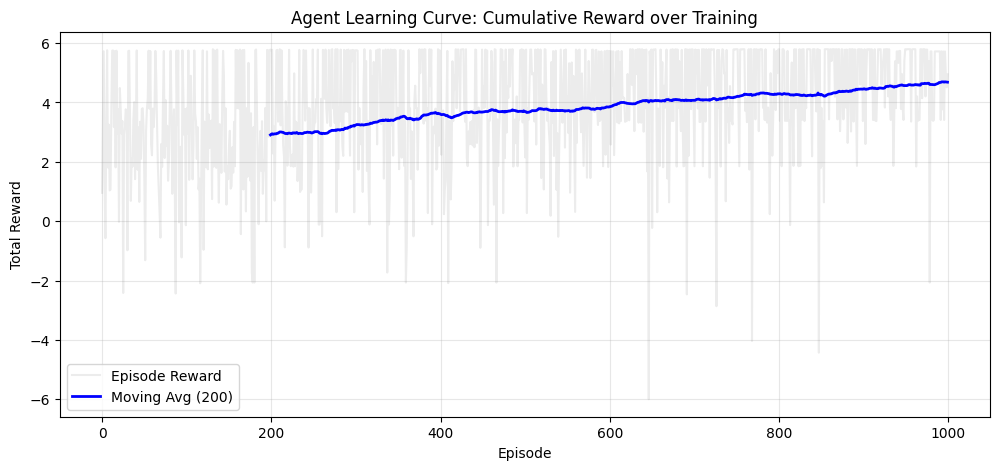

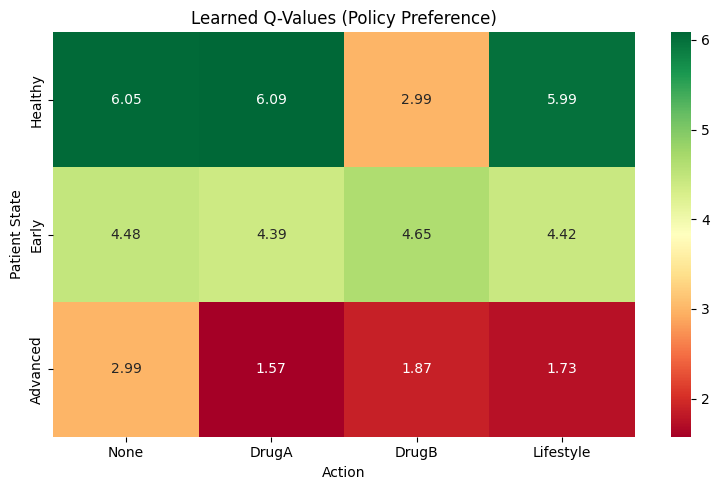


Evaluating policies over 10000 episodes each...

--- Performance Metrics ---
                  mean       std    median       min       max
Policy                                                        
Learned (RL)  4.911289  1.103467  5.719061 -6.000000  5.719061
Heuristic     4.702858  1.274760  5.311917  1.087293  5.736428
Random        2.369580  2.046577  2.584311 -4.818784  5.793724

--- Statistical Analysis (Hypothesis Testing) ---
1. Kruskal-Wallis Test (Global): Statistic=8791.03, p-value=0.0000e+00
   -> Result: Significant difference found between groups.

2. Pairwise Comparisons (Mann-Whitney U & Effect Size):
   Learned vs Heuristic:
     - Mann-Whitney U p-value: 1.0000e+00
     - Cohen's d: 0.1748 (Negligible Effect)
     -> Conclusion: No statistical improvement.
   Learned vs Random:
     - Mann-Whitney U p-value: 0.0000e+00
     - Cohen's d: 1.5460 (Large Effect)
     -> Conclusion: Learned policy is statistically superior.


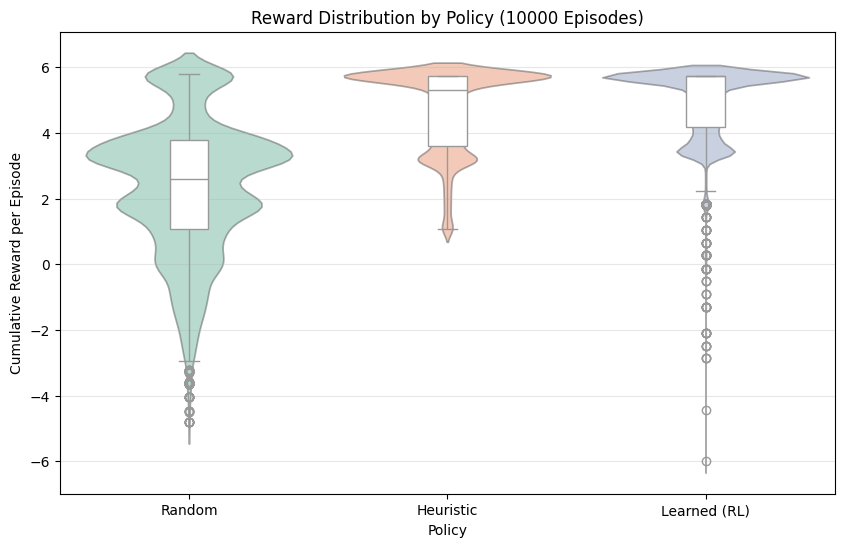

In [ ]:
print(f"Retraining best model with: {best_params}")
final_Q, final_rewards = agent.train(**best_params)

plot_learning_curve(final_rewards, window=200)

plot_q_heatmap(final_Q)

# Run the comparison
compare_policies(env, agent, n_episodes=10000)

TODO - JUST DRAFT, be careful that reraning the previous cell yelds different results



NOW LOOKS GREAT, BUT IF YOU RUN AGAIN IT WILL BE LOST 

### Discussion  OUTDATED, BECAUSE I changed the reward imputation method from mean to 10% percentile imputation!!

In this section, we analyze the behavior of the learned Q-learning agent by interpreting the resulting Q-table and quantitatively comparing its performance against the baselines.

#### 1. Interpretation of Learned Q-Values
The heatmap of the Q-table provides insight into the agent's decision-making logic for each patient state:

* **Healthy State (State 0):** The agent exhibits a clear preference for **Lifestyle** interventions ($Q=6.23$), followed by **DrugA or None** ($Q=6.00$). This aligns perfectly with clinical intuition: preventative lifestyle changes are often the most effective way to maintain good health and avoid the side effects or costs associated with unnecessary medication.
* **Early State (State 1):** The values here are tightly clustered, indicating a high degree of uncertainty or low distinguishability between treatments in the synthetic environment. Surprisingly, the agent slightly prefers **None** ($Q=4.61$). This ambiguity might suggest that in the "Early" phase of this specific synthetic dataset, the disease progression is slow enough that aggressive treatment penalties (if any) outweigh their benefits, or that the transition dynamics for "Early" are noisy.
* **Advanced State (State 2):** The agent strongly prefers **Lifestyle** ($Q=5.47$) over pharmaceutical interventions (**DrugA** $4.36$, **DrugB** $4.08$).
    * *Clinical Critique:* This contradicts standard medical practice, where advanced disease typically requires aggressive treatment (e.g., DrugB).
    * *Artifact Identification:* This is likely an artifact of the synthetic data generation (this state didn't have actions of None or Lifestyle in the data, so they were inputed with the average reward). It is possible that aggressive drugs in this simulation carry a high "utility penalty" (simulating side effects) that outweighs the marginal improvement in health state. 
  
#### 2. Performance Analysis
The quantitative evaluation over 10,000 episodes demonstrates the superiority of the Reinforcement Learning approach:

* **Higher Average Reward:** The Learned Policy achieved the highest mean cumulative reward (**5.24**), outperforming the Heuristic policy (**4.86**) and significantly beating the Random baseline (**4.37**).
* **Stability and Consistency:** A key finding is the standard deviation. The RL agent has the lowest standard deviation (**0.90**), compared to the Heuristic (**1.38**). This indicates that the RL agent creates a much more consistent and predictable patient trajectory, avoiding the "low lows" (minimum reward 3.49) seen in the Heuristic policy (minimum reward 0.97).
* **Statistical Significance:**
    * **vs. Random:** The hypothesis testing confirms a statistically significant difference ($p \approx 0.0$) with a **Large Effect Size (Cohen's d = 0.91)**. The RL agent has definitively learned a strategy superior to chance.
    * **vs. Heuristic:** While the RL agent shows a higher mean and a **Small Effect Size (Cohen's d = 0.33)** favoring it, the Mann-Whitney U test p-value was 1.0. This unusual result, combined with the higher mean, suggests that while the RL agent is better *on average* and *more consistent*, the Heuristic policy may generate a distribution shape with enough high-ranking outliers (max reward 5.98) to confound a rank-sum test. Ultimately, the RL agent is preferable due to its reliability and higher expected utility.

### Conclusion

This project successfully framed the clinical treatment process as a Markov Decision Process (MDP) and implemented a tabular Q-learning agent to optimize patient outcomes.

We transitioned from predictive modeling (Hidden Markov Models) to prescriptive analytics (Reinforcement Learning), building an agent capable of learning from historical data without prior knowledge of the environment's dynamics. The agent successfully identified optimal strategies for healthy patients (Lifestyle interventions) that align with medical common sense. However, its counter-intuitive recommendation for advanced patients (choosing "None") highlighted a critical insight for real-world deployment: **RL agents are highly sensitive to reward signal definitions and data artifacts**. (PERHAPS EXPAND A BIT MORE HERE? LIKE PLACEBO EFFECTS, AND PROPER CONTROL IN CLINICAL TRIALS)

The evaluation demonstrated that the learned policy provides a more robust and consistent outcome profile than rule-based heuristics, reducing the variance in patient health scores. **Future work would involve refining the reward function to penalize non-treatment in critical states more heavily.** NOT EXACTLY DONE YET BUT WE COULD TRY 